Ovaj primer demonstrira koriscenje rekurentnih neuronskih mreza u zadatku automatskog prevodjenja. Bice koriscen **sequence-to-sequence** pristup kojim se recenica izvornog jezika prevodi u recenicu ciljnog jezika. Recenice ce se posmatrati kao sekvence karaktera, iako je u praksi cesci pristup sekvenci reci. Recenice izvornog jezika i recenice ciljnog jezika mogu biti proizvoljnih duzina.  

In [91]:
import numpy as np
from matplotlib import pyplot as plt

In [41]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

#### Ideja algoritma.

Za ucenje ce se koristiti kompozicija mreza koja ima deo za kodiranje i deo za dekodiranje nalik slici. 
<img src='./encoder_decoder.png'>

Zadatak mreze za kodiranje ce biti da svakoj recenici, niski karaktera izvornog jezika, pridruzi odgovarajucu medjureprezentaciju fiksne duzine. Zadatak mreze za dekodiranje ce biti da na osnovu dobijene medjureprezentacije generise odgovarajucu recenicu, nisku karaktera ciljnog jezika.

Mreza za kodiranje i mreza da dekodiranje ce se trenirati zajednicki tako da maksimizuju verovatnocu predvidjanja tacne recenice.  


Obe mreze ce biti LSTM mreze zbog pracenja zavisnosti u ulazima. 

Koraci algoritma:

1) Pocecemo sa sekvencom izvornog jezika i njoj odgovarajucom sekvencom izlaznog jezika. 
2) Deo za kodiranje ce transformisati sekvencu izvornog jezika u vektor stanja i aktivacija koji ce predstavljati medjureprezentaciju recenice. Izlazi mreze nece biti interesantni. Tip ove mreze je many-to-one.  
3) Deo za dekodiranje ce biti treniran tako da uci jezicki model ciljnog jezika. Jezicki model za dati ulazni karakter generise vektor verovatnoca izlaznih karaktera. Ovaj model se uci tako sto se mrezi prosledjuje ulaz oblika $<start\ sequence>c_1c_2...c_k$ i zahteva izlaz oblika $c_1c_2...c_k<end\ sequence>$ (tzv. teacher forcing). Pocetno stanje ove mreze odgovara medjureprezentaciji koju je generisao deo za kodiranje, a ulaz je token koji predstavlja pocetak sekvence. Treniranjem, dekoder uci da generise $targets[t+1...]$ za dato $targets[...t]$ i pocetno stanje.

#### Priprema podataka.

U primeru se koristi englesko-francuski skup podataka koji sadrzi recenice na engleskom jeziku i njihove prevode na francuski jezik. Skup se moze preuzeti sa adrese http://www.manythings.org/anki/.

In [42]:
# recenice izvornog jezika
input_texts = []

# skup karaktera izvornog jezika
input_characters = set()

# recenice ciljnog jezika
target_texts = []

# skup karaktera ciljnog jezika
target_characters = set()

In [43]:
# putanja do skupa podataka koji ce se koristiti
data_path = 'datasets/fra-eng/fra.txt'

In [44]:
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [45]:
# broj raspolozivih recenica
number_of_sentence_pairs = len(lines)
print (number_of_sentence_pairs)

154884


In [46]:
# primer jednog para recenica 
lines[10]

'Wait!\tAttendez !'

In [47]:
# broj recenica koje ce se koristiti za treniranje
number_of_samples = 10000  

In [48]:
# vrsi se izdvajanje recenica izvornog i ciljnog jezika, kao i kreiranje odgovarajucih skupova karaktera 

for line in lines[: min(number_of_samples, number_of_sentence_pairs - 1)]:
    
    input_text, target_text = line.split('\t')
    
    
    # svakoj recenici ciljnog jezika pridruzicemo "tab" kao "start sequence" karakter i "new line" kao "end sequence" karakter
    target_text = '\t' + target_text + '\n'
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [49]:
# sortiramo alfabetski skupove karaktera
input_characters = sorted(list(input_characters))
print ('Karakeri izvornog jezika: ', input_characters)
target_characters = sorted(list(target_characters))
print ('Karakteri ciljnog jezika: ', target_characters)

Karakeri izvornog jezika:  [' ', '!', '$', '%', '&', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Karakteri ciljnog jezika:  ['\t', '\n', ' ', '!', '$', '%', '&', "'", '(', ')', ',', '-', '.', '0', '1', '3', '5', '6', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '«', '»', 'À', 'Ç', 'É', 'Ê', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ', '\u2009', '’', '\u202f']


In [50]:
# odredjujemo broj razlicitih karaktera sa kojima radimo u izvornom i ciljnom jeziku
num_encoder_tokens = len(input_characters)
print ('Broj karaktera izvornog jezika: ', num_encoder_tokens)
num_decoder_tokens = len(target_characters)
print ('Broj karaktera ciljnog jezika: ', num_decoder_tokens)

Broj karaktera izvornog jezika:  71
Broj karaktera ciljnog jezika:  94


In [51]:
# odredjujemo duzinu najduze recenice izvornog tj. ciljnog jezika
max_encoder_seq_length = max([len(txt) for txt in input_texts])
print ('Maksimalna duzina ulazne recenice: ', max_encoder_seq_length)
max_decoder_seq_length = max([len(txt) for txt in target_texts])
print ('Maksimalna duzina ciljne recenice: ', max_decoder_seq_length)

Maksimalna duzina ulazne recenice:  16
Maksimalna duzina ciljne recenice:  59


In [52]:
# formiramo recnike koje preslikavaju karaktere u odgovarajuce numericke vrednosti
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [54]:
# na primer, slovo 'a' engleskog jezika se prislikava u kod 45, 
# dok se slovo 'Ç' francuskog jezika preslikava u kod 75 
print (input_token_index['a'])
print (target_token_index['Ç'])

45
75


** Kreiranje skupova za ucenje. **

Za ucenje su nam potrebna tri skupa: skup koji kodira recenice izvornog jezika (encoder_input_data) koji je nephodan za obucavanje mreze za kodiranje, i dva skupa koja ce biti koriscena od strane mreze za dekodiranje (decoder_input_data i decoder_target_data) kojim ce se uciti jezicki model ciljnog jezika. 

Ovi skupovi ce biti prikazani kao 3D tenzori: svakoj recenici ce biti pridruzen niz brojeva koji odgovaraju pozicijama karaktera u skupu karaktera, a zatim ce se pojedinacni karakteri kodirati odgovarajucim one-hot reprezentacijama. Prva dimenzija ce predstavljati broj recenica sa kojima se radi, druga maksimalni broj karaktera koji se moze naci u recenici, a treca broj karaktera kojim se raspolaze u jeziku. 

In [55]:
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

In [56]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
        
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [57]:
# primeri dobijenih skupova podataka 
encoder_input_data.shape

(10000, 16, 71)

Model mreze sa kojim se radi nije sekvencijalni. Sekvencijalni modeli pretpostavljaju da mreza ima tacno jedan ulaz i tacno jedan izlaz i da se izmedju nalaze uvezani slojevi. Mreza koja se koristi u automatskom prevodjenju zajednicki uci i koder i dekoder sa svojim ulazima. Praksa je da se u ovakvim slucajevima koristi funkcionalni API Keras biblioteke. 

#### Deo za kodiranje. 

In [90]:
# duzina medjureprezentacije recenice izvornog jezika; u literaturi se ovo zove i latentna dimenzija dela za kodiranje
latent_dim = 256  

# ulazni tenzor
encoder_inputs = Input(shape=(None, num_encoder_tokens))

# LSTM sloj: broj LSTM celija u sloju odgovara duzini medjureprezentacije recenice izvornog jezika 
encoder_lstm = LSTM(latent_dim, return_state=True)

# rezultat LSTM sloja je izlaz samo poslednje celije sloja, njene aktivacije i njeno stanje  
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# za dalji rad bice potrebne samo vrednosti aktivacija i stanje mreze - one ce sluziti kao kontekst za prevodjenje
encoder_states = [state_h, state_c]

#### Deo za dekodiranje.

In [59]:
# ulazni tenzor
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# LSTM sloj: broj LSTM celija u sloju odgovara duzini medjureprezentacije recenice dela za kodiranje 
# ovaj sloj ce vratiti izlaz svih pojedinacnih celija, vrednosti njihovih aktivacija i stanja 
# vrednosti stanja necemo koristiti u procesu treniranja modela, ali cemo ih koristiti u delu vezanom za zakljucivanje
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

# prilikom kreiranje sloja, za inicijalno stanje LSTM sloja se koristi medjureprezentacija dobijena od strane dela za kodiranje 
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# kako dekoder koristimo za predikciju verovatnoca pojedinacnih karaktera, dodajemo gusti sloj 
# koji ima onoliko celija koliko ima karaktera u ciljnom jeziku; kao aktivaciju koristimo softmax
decoder_dense = Dense(num_decoder_tokens, activation='softmax')

# izlazni tenzor
decoder_outputs = decoder_dense(decoder_outputs)

#### Konacan model.  

In [60]:
# model ocekuje zadavanje ulaznih tenzora i izlazne transformacije
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [103]:
# duzina paketica za treniranje
batch_size = 64

# broj epoha
epochs = 20

In [104]:
# koristice se rmsprop optimizator, a kao loss funkcija ce se koristiti kategoricka unakrsna entropija
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [105]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose = 0)

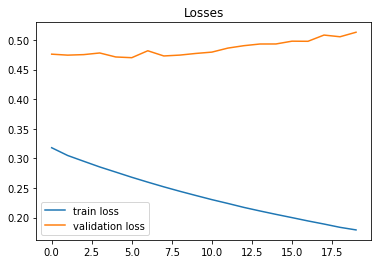

In [106]:
epochs_vals = range(0, epochs)
losses=history.history['loss']
val_losses=history.history['val_loss']
plt.title('Losses')
plt.plot(epochs_vals, losses, label='train loss')
plt.plot(epochs_vals, val_losses, label='validation loss')
plt.legend(loc='best')

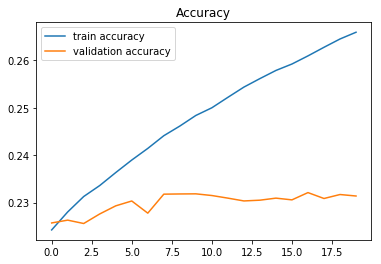

In [107]:
epochs_vals = range(0, epochs)
acc=history.history['acc']
val_acc=history.history['val_acc']
plt.title('Accuracy')
plt.plot(epochs_vals, acc, label='train accuracy')
plt.plot(epochs_vals, val_acc, label='validation accuracy')
plt.legend(loc='best')

In [ ]:
# Cuvamo model
model.save('s2s.h5')

** Evaluacija modela. **

Da bi se evaluirao ovako dobijeni model, potrebno je za recenice skupa za testiranje generisati odgovarajuce prevode. Ovo se radi tako sto se: 

1) ulazna recenica prevede u odgovarajucu medjureprezentaciju tako sto se propusti kroz deo za kodiranje

2) na osnovu ovako dobijene reprezentacije i "start sequence" ulaza, pusta se da dekoder generise recenicu ciljnog jezika. Do kraja recenice se stize ili kada se generise "end sequence" karakter ili kada se dostigne maksimalna dozvoljena duzina. Proces generisanja se sastoji u pracenju pojedinacnih izlaza i njihovom prosledjivanju na ulazu sledecim iteracijama. 

In [73]:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state and a "start of sequence" token as target. Output will be the next target token
# 3) Repeat with the current target token and current states

# Model koji odgovara delu za kodiranje
# nacin zadavanja je u skladu sa funkcionalnim API-jem Keras biblioteke pa se ocekuju ulazni i izlazni tenzor 
encoder_model = Model(encoder_inputs, encoder_states)


encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, 71)          0         
_________________________________________________________________
lstm_6 (LSTM)                [(None, 256), (None, 256) 335872    
Total params: 335,872
Trainable params: 335,872
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Model koji odgovara delu za dekodiranje 

# ulazni tenzori
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# propustanje kroz lstm sloj
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# uvezivanje sa izlaznim slojem
decoder_outputs = decoder_dense(decoder_outputs)

# spajanje svih delova u model 
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, 94)     0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 256)          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 256)          0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, None, 256),  359424      input_7[0][0]                    
                                                                 input_10[0][0]                   
          

In [81]:
# funkcije koje vracaju vrednosti karaktera za zadate numericke vrednosti 
reverse_input_char_index = dict( (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict( (i, char) for char, i in target_token_index.items())

In [82]:
print(reverse_input_char_index[45])
print(reverse_target_char_index[75])

a
Ç


In [83]:
def decode_sequence(input_seq):

    # zbog jednostavnosti je pretpostavka da je velicina paketica za testiranje 1 (batch_size =1)


    # ulazna sekvenca se propusta kroz deo za kodiranje
    states_value = encoder_model.predict(input_seq)

    # generise se vektor koji odgovara "start sequence" karakteru (\t)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    # postavlja se indikator kojim se proverava da li je generisana izlazna recenica ili ne
    stop_condition = False
    
    # izlazna recenica
    decoded_sentence = ''
    
    
    # sve dok se ne stigne do kraja recenice
    while not stop_condition:
        
        # prati se izlaz mreze za dekodiranje: prosledjuje joj se ulazni karakter i trenutno stanje mreze
        # u prvoj iteraciji trenutno stanje mreze odgovara izlazu dela za kodiranje
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # na osnovu izlazne raspodele verovatnoca, odredjuje se karakter sa najvecom verovatnocom 
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        
        # izdvojeni karakter se nadovezuje na izlaznu recenicu
        decoded_sentence += sampled_char

        
        # proverava se da li se stiglo do kraja recenice 
        # tj. da li se doslo do "end sequence" karaktera (znaka za novi red) ili maksimalne duzine izlaza
        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

            
        # pripreme za nerednu iteraciju:
        
        # odredjuje se naredni ulazni karakter - izlaz prethodne iteracije 
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # azuriraju se stanja mreze 
        states_value = [h, c]

    return decoded_sentence

In [89]:
# test na jednom delu skupa za treniranje 
for seq_index in range(10, 40):
    
    # ulazna recenica - izdvajamo je iz skupa koji je koriscen za treniranje 
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    # njoj pridruzen prevod
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)
    print('Humman translated sentence:', target_texts[seq_index])

-
Input sentence: Wait!
Decoded sentence: Arrête de chent !

Humman translated sentence: 	Attendez !

-
Input sentence: Go on.
Decoded sentence: Arrête de chent !

Humman translated sentence: 	Poursuis.

-
Input sentence: Go on.
Decoded sentence: Arrête de chent !

Humman translated sentence: 	Continuez.

-
Input sentence: Go on.
Decoded sentence: Arrête de chent !

Humman translated sentence: 	Poursuivez.

-
Input sentence: I see.
Decoded sentence: Je suis prait de chante.

Humman translated sentence: 	Je comprends.

-
Input sentence: I try.
Decoded sentence: Je suis prait de chante.

Humman translated sentence: 	J'essaye.

-
Input sentence: I won!
Decoded sentence: Je suis prais de coure.

Humman translated sentence: 	J'ai gagné !

-
Input sentence: I won!
Decoded sentence: Je suis prais de coure.

Humman translated sentence: 	Je l'ai emporté !

-
Input sentence: Oh no!
Decoded sentence: Qui l'a parte ?

Humman translated sentence: 	Oh non !

-
Input sentence: Attack!
Decoded sentenc

Formalno, za evaluaciju sistema za prevodjenje se koristi **BLUE** mera. Svakoj od prevedenih recenica se pridruzuje skor sa vrednoscu iz intervala [0, 1], a zatim se dobijene vrednosti uprosece da bi se dobila konacna ocena sistema. Na nivou pojedinacnih recenica skorovi se izracunavaju tako sto se prati broj preklapanja n-grama u recenici prevedenoj od strane sistema i recenici prevedenoj od strane profesionalnih prevodilaca. Vrednosti za $n$ variraju od jezika do jezika,  a obicno vece vrednosti odgovaraju "boljem" prevodu.  

** Zadaci: ** 

* Napraviti zaseban test skup na osnovu recenica koje nisu iskoriscene i testirati model.
* Eksperimentisati sa modelima koji koriste GRU celije. 

#### Korisceni linkovi:

* referentni rad "Sequence to Sequence Learning with Neural Networks" na nivou reci: https://arxiv.org/abs/1409.3215
* rad koji je prethodio ovoj ideji "Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation": https://arxiv.org/abs/1406.1078 

* Keras tutorial: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
* https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py
* http://nmt-keras.readthedocs.io/en/latest/index.html
* TensorFlow tutorial: https://www.tensorflow.org/versions/r1.1/tutorials/seq2seq
* Neural Machine Translation: https://github.com/tensorflow/nmt
* Razne primene generativnog karakterskog modela: http://karpathy.github.io/2015/05/21/rnn-effectiveness/